# Flow Consumption Forecast
candidate: Lior Mayorov

## Research Plan

### Problem statement:

By predicting flow consumption, operators can adjust the operation of compressors to match the actual demand. This ensures that only the necessary amount of compressed air is produced, avoiding overproduction and energy wastage. It can also help in schedualing maintainance in accordance with low flow prediction, thus increasing efficiency.

### Evaluation Method

There are two flow consumptions to predict: the main line's flow consumption (Flow Sensor_flowM3Min) and the other lines, in this dataset, the sauces line (#Flow Sauces_flowM3Min). our target is their summation. We'll predict their sum and asses our outcomes using aggregation-task metrics. For this task, we should use the RMSE metric, since we want to punish large mistakes. Also, I check the MAPE metric to have a since of how large are the errors compared to the data itself.

If I had more knowledge I would set an appropriate amount of time needed for prediction in order to have a significant energy reduction. Than I could test it iterateively. 
In this case I decided to predict and evaluate the last 60 minutes. I didn't test it iterateively since the outcomes weren't promising at all, but that's what should be done to promise a stable and accurate model.

### Methodologies
1. ARIMA - models the relationship between a series of observations and lagged observations, incorporating differencing to make the series stationary. 
2. Neural Network architecture, suited to time series forecasting, like LSTM - could be promising, but is more complex and takes time to develop.
3. Prophet (facebook's model) - an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality. Seems like it works best if there are seasonal effect, may not be optimal for a data with only a few days.

I will choose ARIMA for this task. It's quite simple and fast to use.

### Key Research Questions
The essential information that is needed to accurately predict flow demand consumption is both the main and sauces flow consumption. 
Of course, it would be best to use many of the other columns as features, ideally for neural network. It could also be used in an ARIMA model, where you must provide the "future" features as well, by using past lags of the features in the training and more recent lags in the prediction process. For that, we need to check the correlation in different lags to choose the best lag (limited to how far do we need to predict).
Due to time constraints, I opted not to add exogenious features at all. However I did descrive how I would handle it throughout the process, mostly theoretically.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima_model import ARMA, ARMAResultsWrapper
from sklearn.metrics import mean_squared_error
from typing import Tuple

In [2]:
df = pd.read_csv('plant_data_all.csv', index_col ='iso_time', parse_dates = True)
TARGET_1 = 'Flow Sensor_flowM3Min'
TARGET_2 = '#Flow Sauces_flowM3Min'

Feature Analysis:

I will not add external features to the model, due to lack of time, but ideally it's best to try, and it would definately improve results. So here's a bit of analysis.

First, I can see there's a lot of NaNs and zeros. Let's handle that.

In [37]:
# remove columns with all zeros / NaNs
df = df.loc[:,~((df.isna()) | (df==0)).all(axis=0)]

# remove columns with zero deviation
df = df.loc[:,df.apply(lambda col: col.std() != 0)]

# change the order of the columns so that the targets are first
df = df[[TARGET_1, TARGET_2] + list(set(df.columns)-{TARGET_1, TARGET_2})]

# I can see in the data there are some anomalies. 
# perhaps it's best to change all feature data points above 3 standard deviations above the mean to the mean. but it requires further analysis.

Next, in order to use external features in ARIMA (rather, ARIMAX), one has to provide the test data features as well.
Since we can't do that, we can shift the feature columns at least how much we want to predict.
We decided, for simplicity, we'll predict the last hour.
So we need to check correlation in different shifts for each feature for 60 minutes shift and above.

Here, we'll only show the non-shifted correlation, for demonstration.

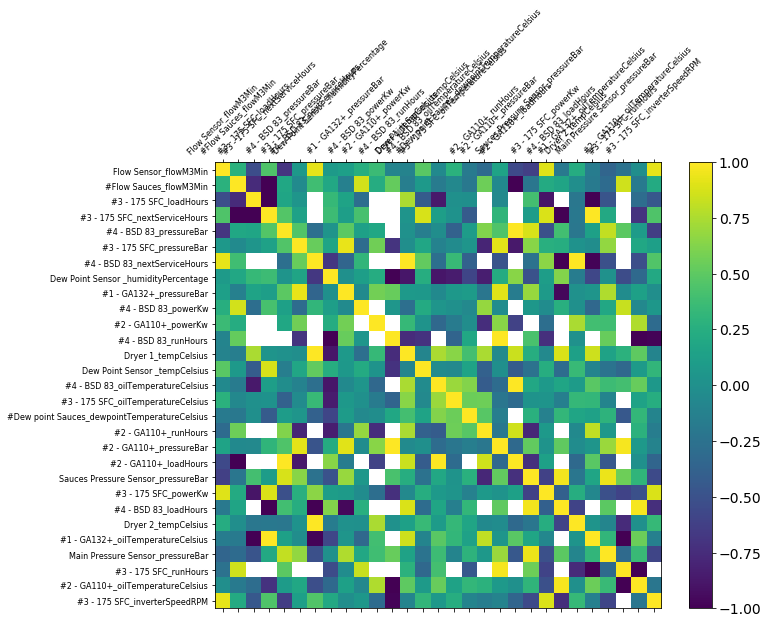

In [59]:
fig = plt.figure(figsize=(10, 8))
plt.matshow(df.corr(), fignum=fig.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=8, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

What we're interested in are the first two columns, showing the correlations between our targets and the features.

In [61]:
corr_th = 0.7
print(f'{TARGET_1} correlated features: \n{list(df.loc[:,df.corr()[TARGET_1].apply(lambda x: abs(x) > corr_th)].columns)[1:]}\n')
print(f'{TARGET_2} correlated features: \n{list(df.loc[:,df.corr()[TARGET_2].apply(lambda x: abs(x) > corr_th)].columns)[1:]}')

Flow Sensor_flowM3Min correlated features: 
['#4 - BSD 83_nextServiceHours', '#3 - 175 SFC_powerKw', '#3 - 175 SFC_inverterSpeedRPM']

#Flow Sauces_flowM3Min correlated features: 
['#3 - 175 SFC_loadHours', '#3 - 175 SFC_nextServiceHours', '#4 - BSD 83_powerKw', '#2 - GA110+_loadHours', '#3 - 175 SFC_runHours']


Note: if we chose to use neural network, this step wouldn't have been neccesary since neural networks are best in revealing *non-linear* connections.
Also, of course, there wouldn't be need in shifting any feature.

Next, we need to decide out frequency, each time step should denote an equal amount of time for all observations.
I decided to resample the data to minutes. seconds was too noisy, an hour loses too much information. Let's see how our data looks:  

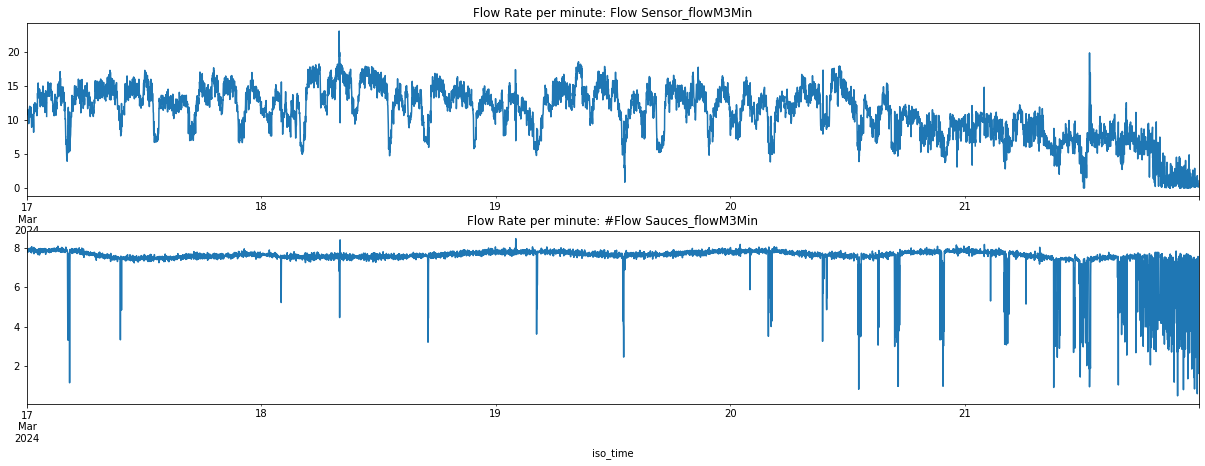

In [3]:
fig, axes = plt.subplots(2,1,figsize=(21,7))
df[TARGET_1].dropna().resample('min').mean().plot( title=f'Flow Rate per minute: {TARGET_1}', ax=axes[0])
df[TARGET_2].dropna().resample('min').mean().plot( title=f'Flow Rate per minute: {TARGET_2}', ax=axes[1])
plt.show()

The main line flow consumption looks to be rather stationary. There's seems to be some patterns there, but it's still very messy. The last hours have much lower values in average than the rest of the data, which is problematic.

The sauces line seems very hard to predict. There are many anomalies and the end of the time series (which will soon be our test data) is very different from the start. I'm afraid that without external features, it will not be enough for an accurate prediction.

Next, let's change the frequency to minutes. From now on, we will disgard the rest of the features...

In [3]:
def resampling_agg(col: pd.Series) -> pd.Series:
    """ Drop NaNs and aggregates a df column by the mean
        It only works for the target columns - flow consumptions that require mean aggregation but
        if we have exog features, we can apply different aggregations (sum, max...) accordingly 
    """
    return col.dropna().mean()
    
df = df[[TARGET_1, TARGET_2]]
df = df.resample('min').apply(resampling_agg).fillna(method='ffill')

If we had external features, we would need to scale the data.
Since we only predict with the history time series, there no need, but the function is provided here

In [7]:
def scale_data(df_train: pd.DataFrame, df_test: pd.DataFrame) -> Tuple[StandardScaler, pd.DataFrame, pd.DataFrame]:
    scaler = StandardScaler()
    scaler.fit(df_train.values)
    scaler.transform(df_train)
    scaler.transform(df_test)

    df_train = pd.DataFrame(scaler.transform(df_train), columns=[TARGET_1, TARGET_2], index=df_train.index)
    df_test = pd.DataFrame(scaler.transform(df_test), columns=[TARGET_1, TARGET_2], index=df_test.index)
    return scaler, df_train, df_test

From looking at the flow data, it seemed that at least the sensor data is stationary, but let's check it with the augmented Dickey-Fuller test.

In [9]:
result = adfuller(df[TARGET_1])
print(f'{TARGET_1}: ADF Statistic: {result[0]}, p-value: {result[1]}')
result = adfuller(df[TARGET_2])
print(f'{TARGET_2}: ADF Statistic: {result[0]}, p-value: {result[1]}')

Flow Sensor_flowM3Min: ADF Statistic: -5.734466500724567, p-value: 6.486364030494905e-07
#Flow Sauces_flowM3Min: ADF Statistic: -5.824062010185137, p-value: 4.1185320978357617e-07


The p-values are both under the significance level(0.05), meaning the data is stationary and there's no need to differentiate it (d = 0).
It's a bit weird for the sauces line, because I thought the anomalies would make it unstationary but maybe the last quarter of the time series, that have a different distibution than the rest, tilts the result. 

Now let's address AR (p), MA (q):

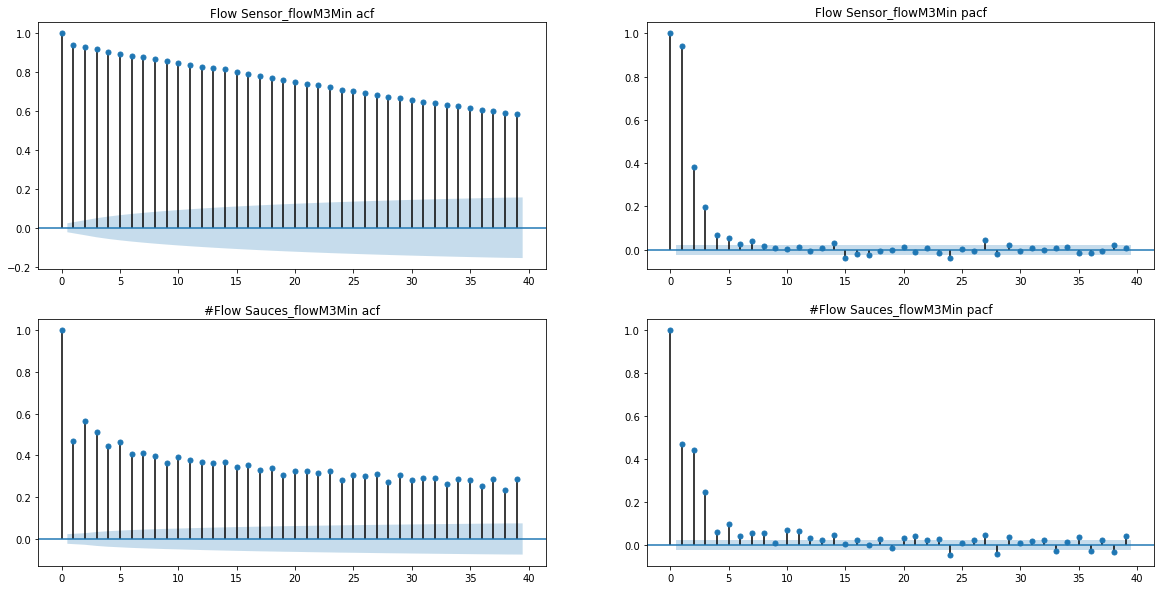

In [10]:
fig, axes = plt.subplots(2,2, figsize=(20,10))

plot_acf(df[TARGET_1], title=f'{TARGET_1} acf' , ax=axes[0, 0])
plot_pacf(df[TARGET_1], title=f'{TARGET_1} pacf' , ax=axes[0,1])

plot_acf(df[TARGET_2], title=f'{TARGET_2} acf' , ax=axes[1, 0])
plot_pacf(df[TARGET_2], title=f'{TARGET_2} pacf' , ax=axes[1,1])

plt.show()

It seems that for both flow variables, the acf graph indicated high values of q.
I will still choose a reasonably low q, to avoid overfitting.

The main's pacf graph shows the best p could be 5 (there are later lags that are also significant, we'll disregard that).
The sauces's pacf inficates p should be 8.

Let's train an ARIMA model!

In [11]:
df_train = df[:-60]
df_test = df[-60:]

model_1 = ARMA(df_train[TARGET_1], order=(5,0,15)) # p=5,d=0,q=40
model_fit_1 = model_1.fit(disp=0)
# print(model_fit.summary())

model_2 = ARMA(df_train[TARGET_2], order=(8,0,15)) # p=8,d=0,q=40
model_fit_2 = model_2.fit(disp=0)

### Evaluation

Let's first visualize the model's prediction of the last our.


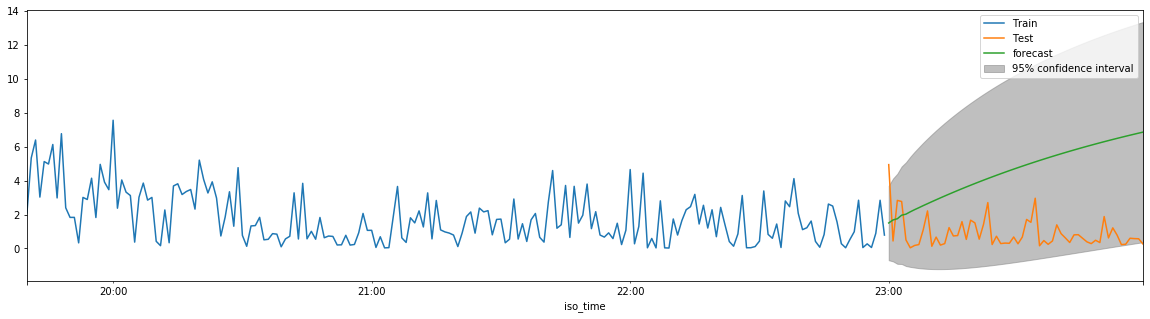

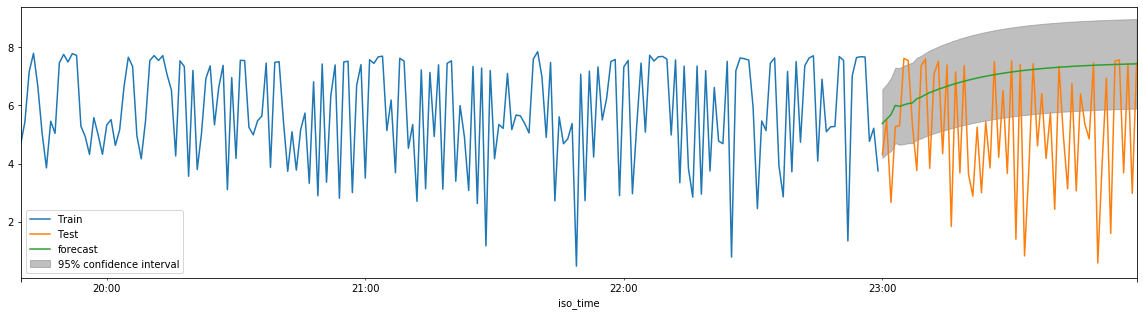

In [22]:
def show_prediction(model_fit: ARMAResultsWrapper, target: str, df_train: pd.DataFrame, df_test: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    df_train[target].iloc[-200:].plot(ax=ax, label='Train')
    df_test[target].plot(ax=ax, label='Test')
    model_fit.plot_predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False, 
                            ax=ax, plot_insample=False) 
    ax.legend()
    plt.show()

show_prediction(model_fit_1, TARGET_1, df_train, df_test)
show_prediction(model_fit_2, TARGET_2, df_train, df_test)

The outcomes aren't good. 

I will evaluate the prediction by summing the flow predictions and comparing it to the real flows' sum using two regression matrics: rmse, mape. 


In [39]:
df_test[f'pred_{TARGET_1}'] = model_fit_1.forecast(steps=len(df_test))[0]
df_test[f'pred_{TARGET_2}'] = model_fit_2.forecast(steps=len(df_test))[0]
df_test['total_flow'] = df_test[TARGET_1] + df_test[TARGET_2]
df_test['pred_total_flow'] = df_test[f'pred_{TARGET_1}'] + df_test[f'pred_{TARGET_2}']

mse = mean_squared_error(df_test['total_flow'].values, df_test['pred_total_flow'].values)
mape = sum(abs((df_test['total_flow'] - df_test['pred_total_flow']) / df_test['total_flow']))/len(df_test)
print(f'RMSE: {np.round(mse**0.5,3)} (average flow: {np.round(df_test["total_flow"].mean(),3)}) \nMAPE: {np.round(mape,3)}')

RMSE: 6.249 (average flow: 6.057) 
MAPE: 1.234


Expectedly, the measures show the outcomes are bad. more than 100% (of the mean) error... I tried to do some manual HPT, but it needs a little more digging in it and unfortunately I didn't have the time.

What I would do to improve outcomes:
1. Use the other data features
2. Perform more thorough hyper parameter tuning, with optuna maybe
3. Use neural network architecture instead of ARIMA, maybe LSTM

Another try with pmdarima that sets p,d,q alone (unsuccesfull):

In [92]:
import pmdarima as pm

model = pm.auto_arima(df_train[TARGET_1], start_p=1, start_q=10,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=20, # maximum p and q
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,10)x(0,0,0,0) [intercept=True]; AIC=21877.363, BIC=21966.718, Time=17.995 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=38591.508, BIC=38605.254, Time=0.112 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=23346.565, BIC=23367.185, Time=0.348 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=32574.206, BIC=32594.827, Time=1.084 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=55545.934, BIC=55552.807, Time=0.062 seconds
Fit ARIMA(0,0,10)x(0,0,0,0) [intercept=True]; AIC=23599.423, BIC=23681.905, Time=10.335 seconds
Fit ARIMA(1,0,9)x(0,0,0,0) [intercept=True]; AIC=21875.478, BIC=21957.960, Time=10.153 seconds
Fit ARIMA(0,0,9)x(0,0,0,0) [intercept=True]; AIC=23843.052, BIC=23918.661, Time=9.356 seconds
Fit ARIMA(1,0,8)x(0,0,0,0) [intercept=True]; AIC=21873.484, BIC=21949.093, Time=8.091 seconds
Fit ARIMA(0,0,8)x(0,0,0,0) [intercept=True]; AIC=24159.397, BIC=24228.131, Time=8.077 seconds
Fit ARIMA(1

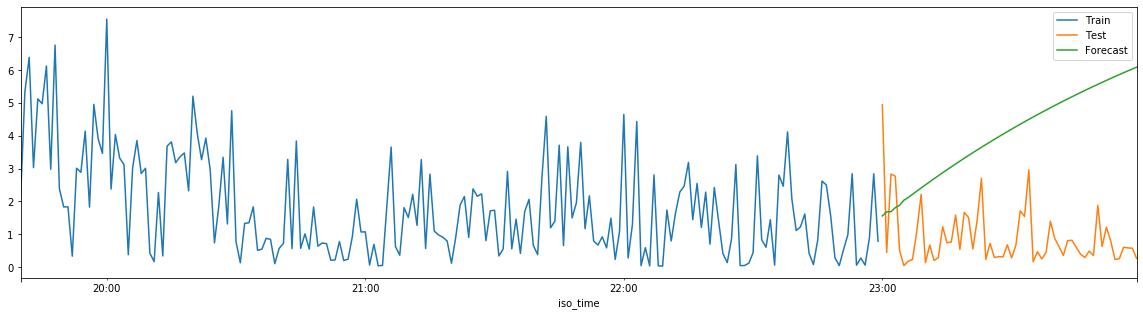

In [95]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
df_train[TARGET_1].iloc[-200:].plot(ax=ax, label='Train')
df_test[TARGET_1].plot(ax=ax, label='Test')

pred_series = pd.Series(model.predict(n_periods=len(df_test)), index=df_test.index)
pred_series.plot(ax=ax, label='Forecast')

ax.legend()
plt.show()

### Insights

Let's say our error is about 10% of the actual flow consumption.
Let's visualize the increase in efficiency:

In [114]:
max_val = 0.11
min_val = 0.09

df_test['fake_pred'] = df_test['total_flow'].apply(lambda f: f + (1+(-2)*np.random.randint(2)) * (np.random.rand() * (max_val-min_val) + min_val) * f)
''' explaination: 
    (1+(-2)*np.random.randint(2)) meaning 1 or -1 randomly
    (np.random.rand() * (max_val-min_val) + min_val) meaning random number in range [0.09, 0.11]
    so for every f we get f +- ~0.1*f -> a close "prediction", around 10% close 
'''

# let's make sure our fake predictions are good, as planned
mse = mean_squared_error(df_test['total_flow'].values, df_test['fake_pred'].values)
mape = sum(abs((df_test['total_flow'] - df_test['fake_pred']) / df_test['total_flow']))/len(df_test)
print(f'RMSE: {np.round(mse**0.5,3)} (average flow: {np.round(df_test["total_flow"].mean(),3)}) \nMAPE: {np.round(mape,3)}')

RMSE: 0.637 (average flow: 6.057) 
MAPE: 0.1


Let's visualize:

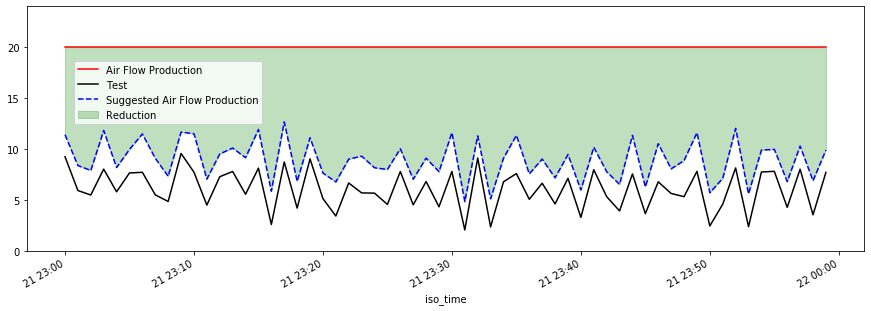

In [115]:
df_test['suggested_air_production'] = df_test['fake_pred'] + 3

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(df_test.index, np.ones((len(df_test))) + 19, label='Air Flow Production', color='red')
df_test['total_flow'].plot(ax=ax, label='Test', color='black')
# df_test['fake_pred'].plot(ax=ax, label='Forecast')
df_test['suggested_air_production'].plot(ax=ax, label='Suggested Air Flow Production', style='--', color='blue')

ax.fill_between(x=df_test.index, y1=np.ones(len(df_test)) + 19, y2=df_test['suggested_air_production'],
                color='green', alpha=0.25, label='Reduction')

ax.set_ylim(0,24)
ax.legend(loc='lower left', bbox_to_anchor=(0.05,0.5))
plt.show()

I made the assumption that there's a steady compressed air production that is well above the actual consumption, since the consumtion is unknown. Without further knowledge I assumed it to be 20 (cubic per minute), for example.

In order to reduce the pruduction of air that's not needed, there's the suggested air flow production (in a broken blue line) which is the predictions (...fake predictions :( ) plus buffer value I randomly set to 3, can set it by a proportion of the mean flow.

The green area, between those two plots, demonstrates the potential savings in the air flow production, and also the reduction in the energy required.